# HEPnOS Autotuning result analysis

This notebook analyzes the results obtained by running DeepHyper with the HEPnOS event selection workflow on the Theta supercomputer. These experiments consist of 115 individual job, each running for 1h on 128 nodes.

## Structure of the results

Each job produced a CSV file containing the list of configurations evaluated, as well as objective achieved by each configuration, and additional information such as the timestamps at which the configuration started running and stopped running, and the nodes on which it ran. The objective corresponds to `-log(runtime)` of the configuration.

Results files are named using the following convention:
- `exp-<MODEL>-<SCALE>-<ENABLE_PEP>-<MORE_PARAMS>-<ITERATION>.csv` for non-transfer-learning experiments;
- `exp-tl-<MODEL>-<SCALE>-<ENABLE_PEP>-<MORE_PARAMS>-<ITERATION>.csv` for non-transfer-learning experiments.

Where `<MODEL>` is either `RF` (random forest), `GP` (gaussian process) or `RAND` (random sampling), `<SCALE>` is the number of nodes used by each HEPnOS workflow instance (4, 8, or 16), `<ENABLE_PEP>` indicates whether the second part of the workflow (event selection step) is enabled (`true` or `false`), `<MORE_PARAMS>` indicates whether a reduced set of parameters is used (`false`) or the full set (`true`), finally as each experiment was reproduced 5 times, the `<ITERATION>` is the iteration number of the experiment.

Experiments were done as follows. For each model, we first run with 4 nodes per instance, without the event selection step, and with a reduced parameter set (`exp-<MODEL>-4-false-false`). We then add the event selection step (`exp-<MODEL>-4-true-false`), then more parameters (`exp-<MODEL>-4-true-true`). Finally we scale to 8 nodes per instance (`exp-<MODEL>-8-true-true`) then 16 (`exp-<MODEL>-16-true-true`). It results that some scenarios were not experimented with (such as 8 or 16 nodes without the event selection, or more parameters without event selection).

For transfer learning (applicable to only the `RF` and `GP` models, since `RAND` only consists of random sampling), we base the transfer learning from the previous corresponding job without transfer learning, as follow.
- `exp-tl-<MODEL>-16-true-true-<X>` uses `exp-<MODEL>-8-true-true`;
- `exp-tl-<MODEL>-8-true-true` uses `exp-<MODEL>-4-true-true`;
- `exp-tl-<MODEL>-4-true-true` uses `exp-<MODEL>-4-true-false`;
- `exp-tl-<MODEL>-4-true-false` uses `exp-<MODEL>-4-false-false`.

In [1]:
# Here is the list of CSV files we will be analyzing
!ls results

exp-GP-16-true-true-1.csv    exp-RF-4-false-false-4.csv
exp-GP-16-true-true-2.csv    exp-RF-4-false-false-5.csv
exp-GP-16-true-true-3.csv    exp-RF-4-true-false-1.csv
exp-GP-16-true-true-4.csv    exp-RF-4-true-false-2.csv
exp-GP-16-true-true-5.csv    exp-RF-4-true-false-3.csv
exp-GP-4-false-false-1.csv   exp-RF-4-true-false-4.csv
exp-GP-4-false-false-2.csv   exp-RF-4-true-false-5.csv
exp-GP-4-false-false-3.csv   exp-RF-4-true-true-1.csv
exp-GP-4-false-false-4.csv   exp-RF-4-true-true-2.csv
exp-GP-4-false-false-5.csv   exp-RF-4-true-true-3.csv
exp-GP-4-true-false-1.csv    exp-RF-4-true-true-4.csv
exp-GP-4-true-false-2.csv    exp-RF-4-true-true-5.csv
exp-GP-4-true-false-3.csv    exp-RF-8-true-true-1.csv
exp-GP-4-true-false-4.csv    exp-RF-8-true-true-2.csv
exp-GP-4-true-false-5.csv    exp-RF-8-true-true-3.csv
exp-GP-4-true-true-1.csv     exp-RF-8-true-true-4.csv
exp-GP-4-true-true-2.csv     exp-RF-8-true-true-5.csv
exp-GP-4-true-true-3.csv     exp-tl-GP-16-true-true-1.csv
exp-GP-4-true-t

## Parameter space

In this section, we list the parameters that make up our parameter space, along with their range, distribution, and descriptions.

| Workflow part | Parameter | Range | Distribution | Description |
|---|---|---|---|---|
| All | BusySpin | True/False | Uniform | Whether Mercury should busy-spin instead of blocking on epoll |
| HEPnOS | ProgressThread | True/False | Uniform | Whether to use a dedicated network progress thread in HEPnOS servers |
|  | NumRPCthreads | [0, 63] | Uniform | Number of threads used by HEPnOs servers to service RPC |
|  | NumEventDBs | [1, 16] | Uniform | Number of database instances per HEPnOS server for Events |
|  | NumProductDBs | [1, 16] | Uniform | Number of database instances per HEPnOS server for Products |
|  | NumProviders | [1, 32] | Uniform | Number of database providers per HEPnOS server |
|  | ThreadPoolType | {fifo, fifo_wait, prio_wait} | Uniform | Argobots thread pool type each provider uses |
|  | PESperNode | {1, 2, 4, 8, 16, 32} | Uniform | Number of HEPnOS server processes per physical node |
| Dataloader | ProgressThread | True/False | Uniform | Whether to use a dedicated network progress thread in Dataloader processes |
|  | WriteBatchSize | [1, 2048] | Log-uniform | Size of the batches (in number of events used when sending data to HEPnOS |
|  | PESperNode | {1, 2, 4, 8, 16, 32} | Uniform | Number of Dataloader processes per physical node |
| PEP | ProgressThread | True/False | Uniform | Whether to use a dedicated network progress thread in PEP processes |
|  | NumThreads | [1, 31] | Uniform | Uniform & Number of threads use to process data in parallel |
|  | InputBatchSize | [8, 1024] | Log-uniform | Batch size (in number of events) to use when loading data from HEPnOS |
|  | OuputBatchSize | [8, 1024] | Log-uniform | Batch size (in number of events) to use when sending data across PEP processes |
|  | PESperNode | {1, 2, 4, 8, 16, 32} | Uniform | Number of PEP processes per physical node |
| Dataloader (cont'd) | LoaderAsync | True/False | Uniform | Use threads to asynchronously send batches to HEPnOS |
|  | LoaderAsyncThreads | [1, 63] | Log-uniform | Number of threads for asynchronous store in Dataloader |
| PEP (cont'd) | UsePreloading | True/False | Uniform | Use batch-prefetching of data products instead of per-product load |
|  | UseRDMA | True/False | Uniform | Use RDMA to transfer data |

## Some python definitions

The bellow code provides utility classes and functions to load the experiments' CSV files, plot them, an compute various quantities. This code is not interesting in itself. For the analysis of the results, please jum to [the analysis section](#analysis) (after having run the cells in this section, of course).

In [2]:
import pandas as pd
import numpy as np
import math
import os
from functools import cache
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Let's define a Job class representing a single repetition of an experiment

class Job:
    
    def __init__(self, model: str, scale: int, enable_pep: bool, more_params: bool, iteration: int, tl=False):
        assert model in ['RAND', 'RF', 'GP']
        assert scale in [4, 8, 16]
        assert iteration in [1, 2, 3, 4, 5]
        if more_params:
            assert enable_pep
        self.__model = model
        self.__scale = scale
        self.__enable_pep = enable_pep
        self.__more_params = more_params
        self.__iteration = iteration
        self.__tl = tl
    
    @property
    def filename(self):
        """Returns the name of the CSV file corresponding to this job."""
        prefix = 'exp-tl' if self.__tl else 'exp'
        enable_pep = str(self.__enable_pep).lower()
        more_params = str(self.__more_params).lower()
        return f'results/{prefix}-{self.__model}-{self.__scale}-{enable_pep}-{more_params}-{self.__iteration}.csv'
    
    @cache
    def load_csv_to_dataframe(self, *, only_timestamps: bool =False):
        """Loads the CSV file of this job and returns a dataframe.
        Only the relevant information (objective and timestamp_end,
        and timestamp_start) are left in the dataframe.
        The objective is transformed back into a runtime = exp(-objective)."""
        filename = self.filename
        if only_timestamps:
            selection = ['timestamp_end', 'timestamp_start']
        else:
            selection = ['objective', 'timestamp_end', 'timestamp_start']
        df = pd.read_csv(filename)[selection]
        # convert timestamp to minutes
        df['timestamp_end'] = df['timestamp_end'].apply(lambda t: t/60)
        df['timestamp_start'] = df['timestamp_start'].apply(lambda t: t/60)
        if not only_timestamps:
            # the objective is expressed as a -log(time), so transform them into a time
            df['objective'] = pd.to_numeric(df['objective'], errors='coerce')
            df.dropna(inplace=True)
            df['objective'] = df['objective'].apply(lambda x: math.exp(-x))
            # compute the running best for this series
            df['best'] = df['objective'].cummin()
            df.sort_values('timestamp_end', inplace=True)
        return df
    
    @cache
    def count_instances(self):
        """Loads the CSV file of this job and counts the failures and timeouts."""
        filename = self.filename
        objective = pd.read_csv(filename)['objective']
        failures = list(objective.loc[pd.to_numeric(objective, errors='coerce').isnull()])
        total = len(objective)
        success = total - len(failures)
        return {'timeout': failures.count('F10001'),
                'failure': failures.count('F10002') + failures.count('F10003'),
                'total': total,
                'success': success}
    
    def plot_scatter(self, ax = None, color: str = 'b'):
        """Draws a scatter plot of this job. Each point represents an evaluation."""
        df = self.load_csv_to_dataframe()
        ax = df.plot(x='timestamp_end', y='objective', kind='scatter',
                xlabel='search time (minutes)', ylabel='run time (sec)',
                ax=ax, fontsize=16, color=color, logy=True,
                yticks=[10,20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600])
        ax.grid(axis='y')
        ax.xaxis.label.set_size(18)
        ax.yaxis.label.set_size(18)
        return ax
        
    def plot_progress(self, ax = None, color: str = 'b'):
        """Plots the evolution of the run-time of the best found configuration
        as time progresses."""
        df = self.load_csv_to_dataframe()
        ax = df.plot(x='timestamp_end', y='best',
            xlabel='search time (minutes)', ylabel='best config (sec)',
            ax=ax, fontsize=16, color=color)
        ax.xaxis.label.set_size(18)
        ax.yaxis.label.set_size(18)
        ax.legend(fontsize=18)
        return ax
    
    @cache
    def compute_utilization(self):
        """Compute the number of running instances (percentage of a max)
        as a function of time, and returns the corresponding dataframe."""
        df = self.load_csv_to_dataframe(only_timestamps=True)
        history = []
        for _, row in df.iterrows():
            history.append((row['timestamp_start'], 1))
            history.append((row['timestamp_end'], -1))
        history = sorted(history, key=lambda v: v[0])
        nb_instances = 0
        timestamp = [0]
        n_instances_running = [0]
        max_nb_instances = 128 / self.__scale
        for time, incr in history:
            nb_instances += incr
            timestamp.append(time)
            n_instances_running.append(nb_instances*100.0/max_nb_instances)
        return pd.DataFrame({'time': timestamp, 'jobs': n_instances_running})
    
    def plot_utilization(self, ax = None, color: str = 'b'):
        """Plots the number of running instances as a function of time."""
        df = self.compute_utilization()
        ax = df.plot(x='time', y='jobs',
            xlabel='search time (minutes)', ylabel='worker utilization (%)',
            ax=ax, fontsize=16, color=color)
        ax.xaxis.label.set_size(18)
        ax.yaxis.label.set_size(18)
        ax.set_ylim(ymin=0, ymax=100)
        ax.legend(['instances'], fontsize=18)
        return ax
    
    def compute_average_utilization(self):
        df = self.compute_utilization()
        df = df.reset_index()
        s = 0.0
        t_prev = 0.0
        for index, row in df.iterrows():
            t = row['time']
            u = row['jobs']
            dt = t - t_prev
            s += dt * u
            t_prev = t
        s /= t
        return s
    
    def compute_best_objective(self):
        df = self.load_csv_to_dataframe()
        return df['best'].iloc[-1]
        
    def compute_average_best_objective(self):
        df = self.load_csv_to_dataframe()
        df = df.reset_index()
        s = 0.0
        o_prev = None
        t_prev = 0.0
        for index, row in df.iterrows():
            t = row['timestamp_end']
            o = row['best']
            dt = t - t_prev
            if o_prev is not None:
                s += dt * o_prev
            else:
                s += dt * o
            o_prev = o
            t_prev = t
        s /= t
        return s

Let's test this class

number of instances = {'timeout': 51, 'failure': 9, 'total': 1012, 'success': 952}
average utilization = 84.62610596225623
average best objective = 15.000207475523537


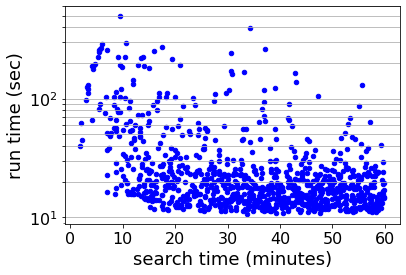

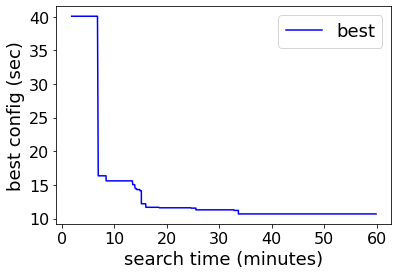

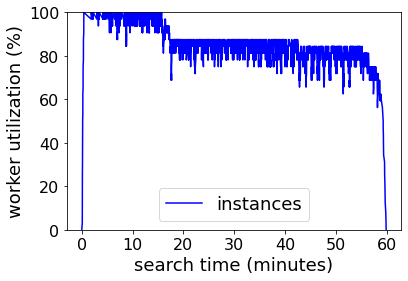

In [4]:
job = Job('RF', 4, True, True, 4)
job.plot_scatter()
job.plot_progress()
job.plot_utilization()
print(f'number of instances = {job.count_instances()}')
print(f'average utilization = {job.compute_average_utilization()}')
print(f'average best objective = {job.compute_average_best_objective()}')

In [5]:
# Let's define a class representing an experiment (5 jobs with the same parameters)

class Exp:
    
    def __init__(self, model: str, scale: int, enable_pep: bool, more_params: bool, tl=False):
        self.__jobs = [Job(model, scale, enable_pep, more_params, i, tl) for i in range(1, 6)]
        
    @property
    def jobs(self):
        return self.__jobs
    
    def count_instances(self):
        result = {'failure': 0, 'timeout': 0, 'total': 0, 'success': 0}
        _min = None
        _max = 0
        for job in self.__jobs:
            f = job.count_instances()
            result['failure'] += f['failure']
            result['timeout'] += f['timeout']
            result['total'] += f['total']
            result['success'] += f['success']
            if _min is None or _min > f['total']:
                _min = f['total']
            if _max < f['total']:
                _max = f['total']
        result['min'] = _min
        result['max'] = _max
        result['average'] = result['total'] / len(self.__jobs)
        return result
        
    @cache
    def build_aggregated_dataframe(self):
        """Builds an aggregated dataframe from the 5 jobs of the experiment.
        This dataframe will gave all the timestamps in its time column, and
        run_1,...5 will contain the best known configuration for each job at
        each timestamp.
        The min, max, and mean column correspond to the minimum, maximum, and
        mean of the run_* columns."""
        dfs = [job.load_csv_to_dataframe().copy() for job in self.__jobs]
        aggregated_df = None
        for i, df in enumerate(dfs):
            df.rename(columns={'best': f'run_{i+1}'}, inplace=True)
            df.drop('objective', axis='columns', inplace=True)
            df.drop('timestamp_start', axis='columns', inplace=True)
            if aggregated_df is None:
                aggregated_df = df
            else:
                aggregated_df = pd.merge_ordered(
                    aggregated_df, df, on='timestamp_end', fill_method='ffill')
        aggregated_df.fillna(method='backfill', axis=0, inplace=True)
        col_names = ['run_1', 'run_2', 'run_3', 'run_4', 'run_5']
        runs_df = aggregated_df[col_names]
        aggregated_df['min'] = runs_df.min(axis=1)
        aggregated_df['max'] = runs_df.max(axis=1)
        aggregated_df['mean'] = runs_df.mean(axis=1)
        return aggregated_df
    
    def plot_progress(self, ax = None, color: str = 'b', legend: str = 'mean'):
        """Plot the progress of the experiment using the min/max/mean of
        the aggregated dataframe as a function of time."""
        df = self.build_aggregated_dataframe()
        ax = df.plot(x='timestamp_end', y=['mean'], ax=ax, color=color,
                     xlabel='search time (minutes)', ylabel='best config (sec)', fontsize=16)
        ax.fill_between(x=df['timestamp_end'], y1=df['min'], y2=df['max'], alpha=0.3,
                        color=color)
        if legend:
            ax.legend([legend, 'min/max'], fontsize=16)
        else:
            ax.get_legend().remove()
        ax.xaxis.label.set_size(18)
        ax.yaxis.label.set_size(18)
        return ax
    
    @staticmethod
    def plot_multiple(exp1, exp2, ax = None, colors = ['blue', 'red'],
                      legends = None):
        """Plots two experiments in the same figure."""
        assert len(colors) == 2
        assert legends is None or len(legends) == 2
        dfs = [exp1.build_aggregated_dataframe(),
               exp2.build_aggregated_dataframe()]
        for i, df in enumerate(dfs):
            ax = df.plot(x='timestamp_end', y=['mean'], ax=ax, color=colors[i],
                         xlabel='search time (minutes)', ylabel='best config (sec)', fontsize=16)
            ax.fill_between(x=df['timestamp_end'], y1=df['min'], y2=df['max'], alpha=0.3,
                            color=colors[i])
        if legends:
            l = []
            for legend in legends:
                l.append(legend)
                l.append('min/max') # legend for the min/max area
            ax.legend(l, fontsize=16)
        else:
            ax.get_legend().remove()
        ax.xaxis.label.set_size(18)
        ax.yaxis.label.set_size(18)
        return ax
            
    @staticmethod
    def __cleanup_dataframes(exp, exp_tl):
        """Helper function to build, cleanup, and merge the aggregated
        dataframes of two experiments. It will return a single dataframe
        with a 'time' column, and a mean-no-tl and mean-tl columns,
        extracting the mean from each experiment respectively."""
        # get time series
        df = exp.build_aggregated_dataframe().copy()
        df_tl = exp_tl.build_aggregated_dataframe().copy()
        # drop unnecessary columns
        for col_name in [f'run_{i}' for i in range(1,6)] + ['min', 'max']:
            df.drop(col_name, axis='columns', inplace=True)
            df_tl.drop(col_name, axis='columns', inplace=True)
        # rename columns
        df.rename(columns={'mean': 'mean-no-tl'}, inplace=True)
        df_tl.rename(columns={'mean': 'mean-tl'}, inplace=True)
        # merge the dataframes
        merged_df = pd.merge_ordered(
            df, df_tl, on='timestamp_end', fill_method='ffill')
        # backfill NaN
        merged_df.fillna(method='backfill', axis=0, inplace=True)
        return merged_df

    @staticmethod
    def compute_expected_improvement_factor(exp, exp_tl):
        """Compute the expected improvement factor between an experiment
        with TL and an experiment without (see paper for definition)."""
        merged_df = Exp.__cleanup_dataframes(exp, exp_tl)
        # compute time deltas
        merged_df['dt'] = merged_df['timestamp_end'].diff()
        merged_df['dt'][0] = 0.0
        # compute instantaneous improvement factor F(t)dt
        merged_df['Fdt'] = merged_df['dt'] * merged_df['mean-no-tl'] / merged_df['mean-tl']
        integral = merged_df['Fdt'].sum()
        expected_improvement = integral / (merged_df['timestamp_end'].iloc[-1] - merged_df['timestamp_end'][0])
        return expected_improvement
    
    @staticmethod
    def compute_expected_speedup(exp, exp_tl, dt: float = 0.0001):
        """Compute the expected speedup between an experiment with TL
        and an experiment without (see paper for definition)."""
        df = Exp.__cleanup_dataframes(exp, exp_tl)
        t_first = df['mean-no-tl'][0]
        t_min = df['mean-no-tl'].iloc[-1]
        num = (t_first - t_min) / dt
        idx_no_tl = 0
        idx_tl = 0
        mean_no_tl = df['mean-no-tl']
        mean_tl = df['mean-tl']
        L = len(mean_tl)
        T = 0.0
        for t in np.linspace(t_min, t_first, num=int(num)):
            while mean_no_tl[idx_no_tl] > t and idx_no_tl < L-1:
                idx_no_tl += 1
            while mean_tl[idx_tl] > t and idx_no_tl < L-1:
                idx_tl += 1
            T_no_tl = df['timestamp_end'][idx_no_tl]
            T_tl = df['timestamp_end'][idx_tl]
            T += T_no_tl/T_tl
        T /= num
        return T
    
    def compute_average_utilization(self):
        utilization = [j.compute_average_utilization() for j in self.jobs]
        return {
            'average': sum(utilization) / len(self.jobs),
            'min': min(utilization),
            'max': max(utilization)
        }
    
    def compute_average_best_objective(self):
        avg_best_objectives = [j.compute_average_best_objective() for j in self.jobs]
        return {
            'average': sum(avg_best_objectives) / len(self.jobs),
            'min': min(avg_best_objectives),
            'max': max(avg_best_objectives)
        }
    
    def compute_best_objective(self):
        best_objectives = [j.compute_best_objective() for j in self.jobs]
        return {
            'average': sum(best_objectives) / len(self.jobs),
            'min': min(best_objectives),
            'max': max(best_objectives)
        }

{'failure': 47,
 'timeout': 788,
 'total': 2628,
 'success': 1793,
 'min': 511,
 'max': 561,
 'average': 525.6}

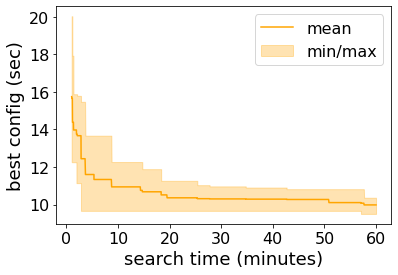

In [6]:
# Let's test this class
exp = Exp('RAND', 4, False, False)
exp.plot_progress(color='orange')
exp.count_instances()

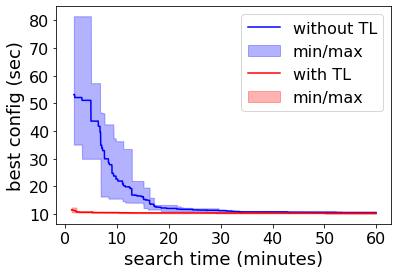

In [7]:
# Let's test plottingt two experiments
exp1 = Exp('RF', 4, True, True)
exp2 = Exp('RF', 4, True, True, tl=True)
plot = Exp.plot_multiple(exp1, exp2, legends=['without TL', 'with TL'])

In [8]:
Exp.compute_expected_improvement_factor(exp1, exp2)

1.5578308413516477

In [9]:
Exp.compute_expected_speedup(exp1, exp2)

10.12928098526856

In [10]:
exp1.compute_average_utilization()

{'average': 89.8438608648439,
 'min': 84.62610596225623,
 'max': 94.04108958825888}

In [11]:
# Let's define a function to load all of the results in a dictionary
def load_all_the_results():
    exps = {}
    for model in ['RAND', 'RF', 'GP']:
        exps[f'{model}-4-F-F'] = Exp(model, 4, False, False)
        exps[f'{model}-4-T-F'] = Exp(model, 4, True, False)
        for scale in [4, 8, 16]:
            exps[f'{model}-{scale}-T-T'] = Exp(model, scale, True, True)
    for model in ['RF', 'GP']:
        exps[f'TL-{model}-4-T-F'] = Exp(model, 4, True, False, tl=True)
        for scale in [4, 8, 16]:
            exps[f'TL-{model}-{scale}-T-T'] = Exp(model, scale, True, True, tl=True)
    return exps

## Plotting and analyzing the results

<a id='analysis'></a>

In this section we will analyze the results. Please follow the comments to play around with the results and plot various graphs.

In [12]:
exps = load_all_the_results()

In [13]:
# Let's compute the expected speedup and improvement factor for all the RF experiments
rf_exp_names = [exp_name for exp_name in exps if exp_name.startswith('RF-')]
for exp_name in rf_exp_names:
    tl_exp_name = f'TL-{exp_name}'
    if tl_exp_name not in exps:
        continue
    exp, tl_exp = exps[exp_name], exps[tl_exp_name]
    f = Exp.compute_expected_improvement_factor(exp, tl_exp)
    s = Exp.compute_expected_speedup(exp, tl_exp)
    print(f'{exp_name}:\t E[F] = {f}\t E[S] = {s}')

RF-4-T-F:	 E[F] = 1.1574515247312127	 E[S] = 1.1717628477984148
RF-4-T-T:	 E[F] = 1.5578308413516477	 E[S] = 10.12928098526856
RF-8-T-T:	 E[F] = 1.9885253076503706	 E[S] = 20.066530787210763
RF-16-T-T:	 E[F] = 3.253504911794609	 E[S] = 39.393880012992625


In [14]:
# Let's plot all the figures

if not os.path.isdir('figures'):
    os.mkdir('figures')

# non-TL experiments
for exp_name, exp in exps.items():
    if exp_name.startswith('TL-'):
        continue
    # plot average and min/max progress out of the 5 repetitions
    print(f'plotting {exp_name}-progress.pdf...')
    exp.plot_progress().get_figure().savefig(
        f'figures/{exp_name}-progress.pdf', bbox_inches='tight')
    plt.close()
    # plot each job's scatter plot and worker utilization
    for i, job in enumerate(exp.jobs):
        print(f'plotting {exp_name}-{i}-scatter.pdf...')
        job.plot_scatter().get_figure().savefig(
            f'figures/{exp_name}-{i}-scatter.pdf', bbox_inches='tight')
        plt.close()
        print(f'plotting {exp_name}-{i}-workers.pdf...')
        job.plot_utilization().get_figure().savefig(
            f'figures/{exp_name}-{i}-workers.pdf', bbox_inches='tight')
        plt.close()
        
# TL experiments (plot against their non-TL counterparts)
for tl_exp_name, tl_exp in exps.items():
    if not tl_exp_name.startswith('TL-'):
        continue
    non_tl_exp_name = tl_exp_name[3:]
    non_tl_exp = exps[non_tl_exp_name]
    print(f'plotting {tl_exp_name}-best.pdf...')
    Exp.plot_multiple(non_tl_exp, tl_exp, legends=['without TL', 'with TL']).get_figure().savefig(
        f'figures/{tl_exp_name}-best.pdf', bbox_inches='tight')
    plt.close()
    # plot each job's scatter plot and worker utilization
    for i, (tl_job, non_tl_job) in enumerate(zip(tl_exp.jobs, non_tl_exp.jobs)):
        print(f'plotting {tl_exp_name}-{i}-scatter.pdf...')
        ax = non_tl_job.plot_scatter(color='blue')
        ax = tl_job.plot_scatter(ax=ax, color='red')
        ax.get_figure().savefig(
            f'figures/{tl_exp_name}-{i}-scatter.pdf', bbox_inches='tight')
        plt.close()
        print(f'plotting {tl_exp_name}-{i}-workers.pdf...')
        ax = tl_job.plot_utilization().get_figure().savefig(
            f'figures/{tl_exp_name}-{i}-workers.pdf', bbox_inches='tight')
        plt.close()

plotting RAND-4-F-F-progress.pdf...
plotting RAND-4-F-F-0-scatter.pdf...
plotting RAND-4-F-F-0-workers.pdf...
plotting RAND-4-F-F-1-scatter.pdf...
plotting RAND-4-F-F-1-workers.pdf...
plotting RAND-4-F-F-2-scatter.pdf...
plotting RAND-4-F-F-2-workers.pdf...
plotting RAND-4-F-F-3-scatter.pdf...
plotting RAND-4-F-F-3-workers.pdf...
plotting RAND-4-F-F-4-scatter.pdf...
plotting RAND-4-F-F-4-workers.pdf...
plotting RAND-4-T-F-progress.pdf...
plotting RAND-4-T-F-0-scatter.pdf...
plotting RAND-4-T-F-0-workers.pdf...
plotting RAND-4-T-F-1-scatter.pdf...
plotting RAND-4-T-F-1-workers.pdf...
plotting RAND-4-T-F-2-scatter.pdf...
plotting RAND-4-T-F-2-workers.pdf...
plotting RAND-4-T-F-3-scatter.pdf...
plotting RAND-4-T-F-3-workers.pdf...
plotting RAND-4-T-F-4-scatter.pdf...
plotting RAND-4-T-F-4-workers.pdf...
plotting RAND-4-T-T-progress.pdf...
plotting RAND-4-T-T-0-scatter.pdf...
plotting RAND-4-T-T-0-workers.pdf...
plotting RAND-4-T-T-1-scatter.pdf...
plotting RAND-4-T-T-1-workers.pdf...
plot

plotting TL-GP-4-T-T-2-workers.pdf...
plotting TL-GP-4-T-T-3-scatter.pdf...
plotting TL-GP-4-T-T-3-workers.pdf...
plotting TL-GP-4-T-T-4-scatter.pdf...
plotting TL-GP-4-T-T-4-workers.pdf...
plotting TL-GP-8-T-T-best.pdf...
plotting TL-GP-8-T-T-0-scatter.pdf...
plotting TL-GP-8-T-T-0-workers.pdf...
plotting TL-GP-8-T-T-1-scatter.pdf...
plotting TL-GP-8-T-T-1-workers.pdf...
plotting TL-GP-8-T-T-2-scatter.pdf...
plotting TL-GP-8-T-T-2-workers.pdf...
plotting TL-GP-8-T-T-3-scatter.pdf...
plotting TL-GP-8-T-T-3-workers.pdf...
plotting TL-GP-8-T-T-4-scatter.pdf...
plotting TL-GP-8-T-T-4-workers.pdf...
plotting TL-GP-16-T-T-best.pdf...
plotting TL-GP-16-T-T-0-scatter.pdf...
plotting TL-GP-16-T-T-0-workers.pdf...
plotting TL-GP-16-T-T-1-scatter.pdf...
plotting TL-GP-16-T-T-1-workers.pdf...
plotting TL-GP-16-T-T-2-scatter.pdf...
plotting TL-GP-16-T-T-2-workers.pdf...
plotting TL-GP-16-T-T-3-scatter.pdf...
plotting TL-GP-16-T-T-3-workers.pdf...
plotting TL-GP-16-T-T-4-scatter.pdf...
plotting TL-

In [15]:
# Let's compute some quantities to plot some bar charts now

index = ["4-F-F", "4-T-F", "4-T-T", "8-T-T", "16-T-T"]
models = ['RAND', 'RF', 'GP', 'TL-RF', 'TL-GP']
data = {}

for model in models:
    data[model] = {
        'evaluations': [],
        'evaluations min': [],
        'evaluations max': [],
        'utilization': [],
        'utilization min': [],
        'utilization max': [],
        'average objective': [],
        'average objective min': [],
        'average objective max': [],
        'best objective': [],
        'best objective min': [],
        'best objective max': []
    }
    for suffix in index:
        exp_name = f'{model}-{suffix}'
        if exp_name not in exps:
            for array_name in data[model]:
                data[model][array_name].append(0.0)
            continue
        exp = exps[exp_name]
        evaluations = exp.count_instances()
        data[model]['evaluations'].append(evaluations['average'])
        data[model]['evaluations min'].append(evaluations['min'])
        data[model]['evaluations max'].append(evaluations['max'])
        utilization = exp.compute_average_utilization()
        data[model]['utilization'].append(utilization['average'])
        data[model]['utilization min'].append(utilization['min'])
        data[model]['utilization max'].append(utilization['max'])
        average_best_objective = exp.compute_average_best_objective()
        data[model]['average objective'].append(average_best_objective['average'])
        data[model]['average objective min'].append(average_best_objective['min'])
        data[model]['average objective max'].append(average_best_objective['max'])
        overall_best_objective = exp.compute_best_objective()
        data[model]['best objective'].append(overall_best_objective['average'])
        data[model]['best objective min'].append(overall_best_objective['min'])
        data[model]['best objective max'].append(overall_best_objective['max'])

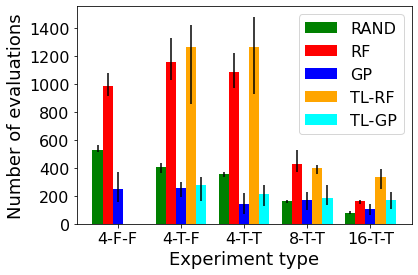

In [16]:
# Let's plot the number of evaluations as a bar chart
evaluations = pd.DataFrame(
    {model : data[model]['evaluations'] for model in models},
    index=index
)
means = evaluations
mins = pd.DataFrame(
    {model : data[model]['evaluations min'] for model in models},
    index=index
)
maxs = pd.DataFrame(
    {model : data[model]['evaluations max'] for model in models},
    index=index
)
errors = [[means[c] - mins[c], maxs[c] - means[c]] for c in evaluations.columns]

ax = evaluations.plot.bar(rot=0, color=['green', 'red', 'blue', 'orange', 'cyan'], fontsize=16,
                          ylabel='Number of evaluations', xlabel='Experiment type',
                          yerr=errors, width=0.8)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.legend(fontsize=16)
ax.get_figure().savefig(f'figures/bar-chart-evaluations.pdf', bbox_inches='tight')


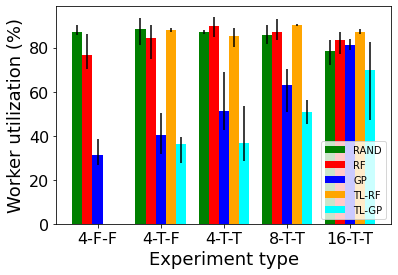

In [17]:
# Let's plot the average worker utilization as a bar chart
utilization = pd.DataFrame(
    {model : data[model]['utilization'] for model in models},
    index=index
)
means = utilization
mins = pd.DataFrame(
    {model : data[model]['utilization min'] for model in models},
    index=index
)
maxs = pd.DataFrame(
    {model : data[model]['utilization max'] for model in models},
    index=index
)
errors = [[means[c] - mins[c], maxs[c] - means[c]] for c in utilization.columns]

ax = utilization.plot.bar(rot=0, color=['green', 'red', 'blue', 'orange', 'cyan'], fontsize=16,
                          ylabel='Worker utilization (%)', xlabel='Experiment type',
                          yerr=errors, width=0.8)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.legend(loc='lower right')
ax.get_figure().savefig(f'figures/bar-chart-utilization.pdf', bbox_inches='tight')

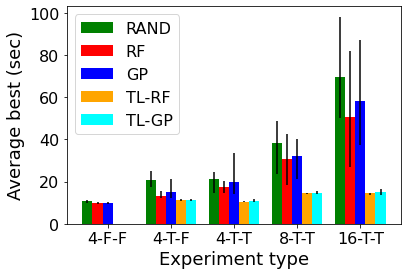

In [18]:
# Let's plot the average best objective as a bar chart
objective = pd.DataFrame(
    {model : data[model]['average objective'] for model in models},
    index=index
)
means = objective
mins = pd.DataFrame(
    {model : data[model]['average objective min'] for model in models},
    index=index
)
maxs = pd.DataFrame(
    {model : data[model]['average objective max'] for model in models},
    index=index
)
errors = [[means[c] - mins[c], maxs[c] - means[c]] for c in objective.columns]

ax = objective.plot.bar(rot=0, color=['green', 'red', 'blue', 'orange', 'cyan'], fontsize=16,
                        ylabel='Average best (sec)', xlabel='Experiment type',
                        yerr=errors, width=0.8)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.legend(fontsize=16)
ax.get_figure().savefig(f'figures/bar-chart-average-best.pdf', bbox_inches='tight')

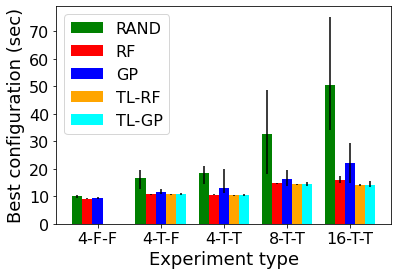

In [19]:
# Let's plot the overall best objective as a bar chart
best = pd.DataFrame(
    {model : data[model]['best objective'] for model in models},
    index=index
)
means = best
mins = pd.DataFrame(
    {model : data[model]['best objective min'] for model in models},
    index=index
)
maxs = pd.DataFrame(
    {model : data[model]['best objective max'] for model in models},
    index=index
)
errors = [[means[c] - mins[c], maxs[c] - means[c]] for c in best.columns]

ax = best.plot.bar(rot=0, color=['green', 'red', 'blue', 'orange', 'cyan'], fontsize=16,
                   ylabel='Best configuration (sec)', xlabel='Experiment type',
                   yerr=errors, width=0.8)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.legend(fontsize=16)
ax.get_figure().savefig(f'figures/bar-chart-overall-best.pdf', bbox_inches='tight')